### Each file contains four parts separated by ‘\n\n’. They are
    1. url of the original article;
    2. sentences in the article and their labels (for sentence-based extractive summarization);
    3. extractable highlights (for word extraction-based abstractive summarization);
    4. named entity mapping.

### Sentence labels. There are three labels for the sentences: 1, 2 and 0. 

    - 1: sentence should extracted; 
    - 2: sentence might be extracted; 
    - 0: sentence shouldn't be extracted.

### Extractable highlights

The extractable highlights are created by examining if a word (or its morphological transformation) in the highlight appears in the article or a general purpose stop-word list, which together constitute the output space (i.e., the allowed vocabulary during summary generation).

In [ ]:
import os
# import urllib2
from urllib.request import urlopen
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [3]:
def buildEntityDictionary(input_path, filenames):
    # Swapping in the entity names
    entitykey, entityname = [], []
    for filename in filenames:
        f = open(os.path.join(input_path, filename))
        data = f.read()
        entities = data.split("\n\n")[3]

        for entity in entities.split("\n"):
            entitykey.append( entity.split(":")[0] )
            entityname.append( entity.split(":")[1] )

    edictionary = dict(zip(entitykey, entityname))
    return edictionary    

def cleandata(input_path, files, edict):
    f = open(os.path.join(input_path, files))
    data = f.read()

    url  = data.split("\n\n")[0]
    article = data.split("\n\n")[1]
    nuggets = data.split("\n\n")[2]
    entities = data.split("\n\n")[3]

    # Parsing the sentences and substituting
    sentencelist, sentencelabel = [], []
    for sentence in article.split("\n"):
        # Swapping in the entity names
        sentencelabel.append(int(sentence.split("\t\t\t")[1]))
        sentence = sentence.split("\t\t\t")[0]
        newsentence = ' '.join([edict[word] if word in edict else word for word in sentence.split(" ")])
        sentencelist.append(newsentence)

    # Collecting the sentences in a list
    df = pd.DataFrame(sentencelist, columns=['Sentence'])
    df['Label'] = sentencelabel

    # Extracting the nuggets
    highlight = []
    for nugget in nuggets.split("\n"):
        newnugget = ' '.join([edict[word] if word in edict else word for word in nugget.split(" ")])
        highlight.append(newnugget)

    nuggets = pd.DataFrame(highlight, columns=['Nugget'])
    # Getting the title/query
#    html = requests.get(url).text
    html = urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')
    try:
        title = soup.findAll("title")[0].text
    except:
        title = 'MISSING'
    return title, nuggets, df, df.shape[0]

In [7]:
# inputpath = '/Users/franciscojavierarceo/GitHub/DeepNLPQLearning/data/neuralsum/cnn/training/'
outputpath = '/Users/franciscojavierarceo/GitHub/DeepNLPQLearning/data2/0-output'
# datafiles = os.listdir(inputpath)

In [4]:
edict = buildEntityDictionary(inputpath, datafiles)

In [61]:
filelist = os.listdir(outputpath)
finished = [int(x.replace("q",'').replace("_stream.csv", '')) for x in filelist if 'stream.csv' in x]
finishedval = max(finished)
# outdf = pd.DataFrame(columns=['query_id','query','streamSize','query_filename', 'outfile_name', 'nuggetfilename'])

for i, datafile in enumerate(datafiles):
    if i > finishedval:
        query, nuggets, stream, streamSize = cleandata(inputpath, datafile, edict)
        outfilename = 'q%i_stream.csv' % i
        nuggetfilename = 'q%i_nuggets.csv' % i
        tmpdf = pd.DataFrame( [i, query, streamSize, datafile, outfilename, nuggetfilename] ).T
        tmpdf.columns = ['query_id','query','streamSize','query_filename', 'outfile_name', 'nuggetfilename']
        outdf = pd.concat([outdf, tmpdf], axis=0)
        stream.to_csv(os.path.join(outputpath, outfilename), index=False)
        nuggets.to_csv(os.path.join(outputpath, nuggetfilename), index=False)

In [73]:
outdf.to_csv("/Users/franciscojavierarceo/GitHub/DeepNLPQLearning/data2/1-output/cnn_trainingqueries.csv", 
             index=False, encoding='utf-8')

In [93]:
finalinputdir = '/Users/franciscojavierarceo/GitHub/DeepNLPQLearning/data2/0-output/'
finaloutputdir = '/Users/franciscojavierarceo/GitHub/DeepNLPQLearning/data2/1-output/'

finalinputfiles = os.listdir(finalinputdir)

# Validating the summaries

In [194]:
streams = [(int(x.split("_")[0].replace("q",'')), x) for x in finalinputfiles if '_stream.csv' in x]
nuggets = [(int(x.split("_")[0].replace("q",'')), x) for x in finalinputfiles if '_nuggets.csv' in x]

streamsummary = pd.DataFrame(streams, columns=['query_id','streamname'])
nuggetsummary = pd.DataFrame(nuggets, columns=['query_id','nuggetname'])

fulldf = pd.merge(streamsummary, nuggetsummary, how='inner', left_on = 'query_id', right_on='query_id')
dupes = outdf.drop_duplicates(inplace=False)['query_id'].value_counts().reset_index()
dupes.columns = ['query_id', 'count']
dupes = dupes[dupes['count'] > 1]
dedupefilter = outdf['query_id'].isin(dupes['query_id'])==False

In [193]:
# Exporting files
outdf[dedupefilter].to_csv(
    "/Users/franciscojavierarceo/GitHub/DeepNLPQLearning/data2/1-output/cnn_trainingqueries.csv", 
             index=False, encoding='utf-8')

In [198]:
outdf.shape[0], outdf[dedupefilter]['streamSize'].sum()

(85198, 2541426)

In [282]:
outdf[dedupefilter]['streamSize'].sum() / float(outdf.shape[0])

29.829643888354187

# Reading data back in 

In [5]:
import os
#import urllib2
#import requests
import pandas as pd
#from bs4 import BeautifulSoup
from joblib import Parallel, delayed

In [2]:
finalinputdir = '/home/francisco/GitHub/DQN-Event-Summarization/data/0-output/'
finaloutputdir = '/home/francisco/GitHub/DQN-Event-Summarization/data/1-output/'

finalinputfiles = os.listdir(finalinputdir)

In [3]:
outdf = pd.read_csv("/home/francisco/GitHub/DQN-Event-Summarization/data/1-output/cnn_trainingqueries.csv")

In [4]:
def extract_data(inputdir, odf_row):
        cleanedstreams = pd.read_csv(inputdir + odf_row['outfile_name'])
        cleanedstreams['query'] = odf_row['query'].replace(" - CNN.com", "")
        cleanedstreams['query_id'] = odf_row['query_id']
        cleanedstreams['true_summary'] = ' '.join(cleanedstreams[cleanedstreams['Label']==1].Sentence)
        cleanedstreams['sentence_idx'] = cleanedstreams.index
        return cleanedstreams

In [ ]:
streams = Parallel(n_jobs=-1)(
    delayed(extract_data)(finalinputdir, row) for i, row in outdf.iterrows()
)

In [6]:
cleanedstreams = pd.concat(streams)
cleanedstreams = cleanedstreams[['query_id', 'sentence_idx', 'Label','query','Sentence', 'true_summary']]
cleanedstreams.columns = [x.lower() for x in cleanedstreams.columns]

In [7]:
cleanedstreams.head()

,query_id,sentence_idx,label,query,sentence,true_summary
0,0,0,1,Mistaken for your child's grandmother,"-- i 'm 45 , and my son is 7","-- i 'm 45 , and my son is 7 once in a while ,..."
1,0,1,1,Mistaken for your child's grandmother,"once in a while , i still get carded when i tr...","-- i 'm 45 , and my son is 7 once in a while ,..."
2,0,2,1,Mistaken for your child's grandmother,i was 38 when Dominican Republic Emergency Ope...,"-- i 'm 45 , and my son is 7 once in a while ,..."
3,0,3,1,Mistaken for your child's grandmother,both incidents took place after i moved from A...,"-- i 'm 45 , and my son is 7 once in a while ,..."
4,0,4,2,Mistaken for your child's grandmother,i thought about the incidents when i read a re...,"-- i 'm 45 , and my son is 7 once in a while ,..."


In [8]:
cleanedstreams.to_csv(
    "/Users/franciscojavierarceo/GitHub/DeepNLPQLearning/data2/1-output/cnn_trainingstreams.csv", 
             index=False, encoding='utf-8'
)

In [10]:
cleanedstreams.head()

,query_id,sentence_idx,label,query,sentence,true_summary
0,0,0,1,Mistaken for your child's grandmother,"-- i 'm 45 , and my son is 7","-- i 'm 45 , and my son is 7 once in a while ,..."
1,0,1,1,Mistaken for your child's grandmother,"once in a while , i still get carded when i tr...","-- i 'm 45 , and my son is 7 once in a while ,..."
2,0,2,1,Mistaken for your child's grandmother,i was 38 when Dominican Republic Emergency Ope...,"-- i 'm 45 , and my son is 7 once in a while ,..."
3,0,3,1,Mistaken for your child's grandmother,both incidents took place after i moved from A...,"-- i 'm 45 , and my son is 7 once in a while ,..."
4,0,4,2,Mistaken for your child's grandmother,i thought about the incidents when i read a re...,"-- i 'm 45 , and my son is 7 once in a while ,..."


# Tokenize data

In [1]:
import os
import re
import sys
import pickle
import csv
import gzip
import numpy as np
from itertools import chain
from bs4 import BeautifulSoup
import pandas as pd
from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS
from collections import defaultdict

Slow version of gensim.models.doc2vec is being used


In [40]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
! pwd

/Users/franciscojavierarceo/GitHub/DeepNLPQLearning/Code/Utils


In [8]:
df1 = pd.read_csv("/home/francisco/GitHub/DQN-Event-Summarization/data/cnn_tokenized/cnn_trainingstreams_tokenized.csv")
df1['slen'] = df1.apply(lambda row: len(row['stokens'].split(" ")), axis=1)

In [35]:
sdf = pd.concat([df1['slen'].value_counts(), df1['slen'].value_counts(normalize=True)], axis=1).reset_index()
sdf.columns = ['sent_len', 'count', 'percent']
sdf.sort_values(by='sent_len', inplace=True)
sdf.reset_index(inplace=True, drop=True)
sdf['cumpercent'] = sdf['percent'].cumsum()

In [45]:
sdf[sdf['cumpercent'] <=0.99].shape

(56, 4)

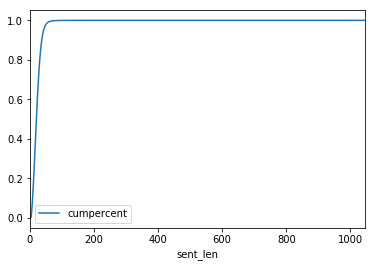

In [41]:
sdf.plot(x='sent_len', y='cumpercent')

In [46]:
sdf2 = pd.concat([df1['sentence_idx'].value_counts(), df1['sentence_idx'].value_counts(normalize=True)], axis=1).reset_index()
sdf2.columns = ['sidx', 'counrt', 'percent']
sdf2.sort_values(by='sidx', inplace=True)
sdf2.reset_index(inplace=True, drop=True)
sdf2['cumpercent'] = sdf2['percent'].cumsum()

In [53]:
sdf2[sdf2['cumpercent'] <=0.99].shape

(67, 4)

In [10]:
df1.head()

,query_id,sentence_idx,query,sentence,true_summary,stokens,tstokens,qtokens
0,0,0,Mistaken for your child s grandmother,i m 45 and my son is 7,i m 45 and my son is 7 once in a while i still...,0 1 2 3 4 5 6 7,0 1 2 3 4 5 6 7 20001 8 9 10 0 11 12 13 14 0 2...,20001 102 33 149 105 48
1,0,1,Mistaken for your child s grandmother,once in a while i still get carded when i try ...,i m 45 and my son is 7 once in a while i still...,20001 8 9 10 0 11 12 13 14 0 20001 15 16 17 18...,0 1 2 3 4 5 6 7 20001 8 9 10 0 11 12 13 14 0 2...,20001 102 33 149 105 48
2,0,2,Mistaken for your child s grandmother,i was 38 when Dominican Republic Emergency Ope...,i m 45 and my son is 7 once in a while i still...,0 23 51 14 52 53 54 55 56 23 57 58 59 9 60 61 ...,0 1 2 3 4 5 6 7 20001 8 9 10 0 11 12 13 14 0 2...,20001 102 33 149 105 48
3,0,3,Mistaken for your child s grandmother,both incidents took place after i moved from A...,i m 45 and my son is 7 once in a while i still...,68 69 70 71 72 0 73 74 75 76 77 15 78 79 80 81...,0 1 2 3 4 5 6 7 20001 8 9 10 0 11 12 13 14 0 2...,20001 102 33 149 105 48
4,0,4,Mistaken for your child s grandmother,i thought about the incidents when i read a re...,i m 45 and my son is 7 once in a while i still...,0 94 90 37 69 14 0 95 9 26 78 79 96 20001 97 9...,0 1 2 3 4 5 6 7 20001 8 9 10 0 11 12 13 14 0 2...,20001 102 33 149 105 48


In [54]:
df1.head()

,query_id,sentence_idx,query,sentence,true_summary,stokens,tstokens,qtokens,slen
0,0,0,Mistaken for your child s grandmother,i m 45 and my son is 7,i m 45 and my son is 7 once in a while i still...,0 1 2 3 4 5 6 7,0 1 2 3 4 5 6 7 20001 8 9 10 0 11 12 13 14 0 2...,20001 102 33 149 105 48,8
1,0,1,Mistaken for your child s grandmother,once in a while i still get carded when i try ...,i m 45 and my son is 7 once in a while i still...,20001 8 9 10 0 11 12 13 14 0 20001 15 16 17 18...,0 1 2 3 4 5 6 7 20001 8 9 10 0 11 12 13 14 0 2...,20001 102 33 149 105 48,56
2,0,2,Mistaken for your child s grandmother,i was 38 when Dominican Republic Emergency Ope...,i m 45 and my son is 7 once in a while i still...,0 23 51 14 52 53 54 55 56 23 57 58 59 9 60 61 ...,0 1 2 3 4 5 6 7 20001 8 9 10 0 11 12 13 14 0 2...,20001 102 33 149 105 48,27
3,0,3,Mistaken for your child s grandmother,both incidents took place after i moved from A...,i m 45 and my son is 7 once in a while i still...,68 69 70 71 72 0 73 74 75 76 77 15 78 79 80 81...,0 1 2 3 4 5 6 7 20001 8 9 10 0 11 12 13 14 0 2...,20001 102 33 149 105 48,39
4,0,4,Mistaken for your child s grandmother,i thought about the incidents when i read a re...,i m 45 and my son is 7 once in a while i still...,0 94 90 37 69 14 0 95 9 26 78 79 96 20001 97 9...,0 1 2 3 4 5 6 7 20001 8 9 10 0 11 12 13 14 0 2...,20001 102 33 149 105 48,24


In [58]:
df1['stokens2'] = df1.apply(lambda row: ' '.join(row['stokens'].split(" ")[0:66]) , axis=1)

In [59]:
df1['slen2'] = df1.apply(lambda row: len(row['stokens2'].split(" ")), axis=1)

In [60]:
df1['stokens2'].head()

0                                      0 1 2 3 4 5 6 7
1    20001 8 9 10 0 11 12 13 14 0 20001 15 16 17 18...
2    0 23 51 14 52 53 54 55 56 23 57 58 59 9 60 61 ...
3    68 69 70 71 72 0 73 74 75 76 77 15 78 79 80 81...
4    0 94 90 37 69 14 0 95 9 26 78 79 96 20001 97 9...
Name: stokens2, dtype: object